In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
!pip install tqdm
from tqdm import tqdm
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("processed_train.csv")

In [4]:
df.head()

,Unnamed: 0,ORIGIN_STAND,TAXI_ID,LEN,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,0,0.0,366,330,7,1,0,0,0,0,1
1,1,7.0,370,270,7,1,0,0,0,1,0
2,2,0.0,203,960,7,1,0,0,0,0,1
3,3,0.0,329,630,7,1,0,0,0,0,1
4,4,0.0,216,420,7,1,0,0,0,0,1


In [5]:
#Removing these for this MLP model only
df = df.drop(columns=["Unnamed: 0"])
#df = df.drop(columns=["Unnamed: 0", "TRIP_ID", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP"])
#df = df.drop(columns=["Unnamed: 0", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP", "YR_2014", "YR"])

In [6]:
df_sample = df#.sample(frac=0.5)

In [7]:
stand_size = len(df["ORIGIN_STAND"].unique())
taxi_size = len(df["TAXI_ID"].unique())
month_size = len(df["MON"].unique())
day_size = len(df["DAY"].unique())
hr_size = len(df["HR"].unique())
wk_size = len(df["WK"].unique())
sizes = [stand_size, taxi_size, month_size, day_size, hr_size, wk_size]

In [8]:
df_len = df_sample["LEN"]
df_sample = df_sample.drop(columns=["LEN"])

In [9]:
#Offset month and day by one because it originally starts at 1
#Helps with embedding later
df_sample["MON"] = df_sample["MON"] - 1
df_sample["DAY"] = df_sample["DAY"] - 1

In [10]:
len(df_sample)

1656486

In [11]:
#Normalize each columns
#df_sample = (df_sample-df_sample.min())/(df_sample.max()-df_sample.min())

In [12]:
df_sample.head()

,ORIGIN_STAND,TAXI_ID,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,0.0,366,6,0,0,0,0,0,1
1,7.0,370,6,0,0,0,0,1,0
2,0.0,203,6,0,0,0,0,0,1
3,0.0,329,6,0,0,0,0,0,1
4,0.0,216,6,0,0,0,0,0,1


In [13]:
features = df_sample.values

In [14]:
input_size = len(sizes) * (10 - 1) + len(features[0])
input_size

63

In [15]:
x = torch.tensor(np.array(features), dtype = torch.float).to(device)

y = torch.tensor(np.array(df_len.values), dtype = torch.float).to(device)

data = list(zip(x, y))
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data, test_data, val_data = torch.utils.data.random_split(data, [train_size, test_size, val_size])

In [24]:
batch_size = 5
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = False)
# train_loader = train_data
# valid_loader = val_data
# test_loader = test_data

In [25]:
len(train_data), len(test_data), len(val_data)

(1325188, 165650, 165648)

In [42]:
learning_rate = 1e-5

In [27]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(input_size, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
# #     torch.nn.Linear(1024, 1024),
#     #torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1),
# ).to(device)

In [28]:
class MLP(nn.Module):
    def __init__(self, sizes, input_size, hidden_size):
        super(MLP, self).__init__()
        #Embed layers for categorical features
        self.sizes_len = len(sizes)
        self.embeddings = [nn.Embedding(size, 10) for size in sizes]
        self.is_embedding = True
        # This is our holy embedding layer - the topic of this post
#         self.embedding_stand = nn.Embedding(stand_size, 10)
#         self.embedding_taxi = nn.Embedding(taxi_size, 10)

        # FC layers
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        
    def forward(self, x):
        # Pass input through the embedding layers
        if self.is_embedding:
            embeds = []
            for i, embedding in enumerate(self.embeddings):
                x_temp = embedding(torch.LongTensor((x[:, i].to("cpu").to(torch.long))))
                embeds.append(x_temp)

    #         x0 = self.embedding_stand(torch.LongTensor((x[:, 0].to("cpu").to(torch.long))).to(device))
    #         x1 = self.embedding_taxi(torch.LongTensor((x[:, 1].to("cpu").to(torch.long))).to(device))
            embeds = torch.hstack(embeds)

            #Take out the first two columns, add the new embedded vectors 
            x = torch.cat([x[:, self.sizes_len:], embeds.to(device)], dim=1).to(device)
        
        #Fully connected  layers
        return self.layers(x)
model = MLP(sizes, input_size, 1024).to(device)

In [29]:
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
from tqdm import trange
def train_epoch(train_data, model, optimizer, loss_fn, batch_size):
    losses = []
    train_len = len(train_data)
    
    # get a batch of training data
    for x, y in tqdm(train_data):
        # make predictions for this batch
        y_pred = model(x)
        
        # Compute the RSME loss
        loss = torch.sqrt(loss_fn(y_pred, y))
        
        # Backpropagation
        # zero out the gradients so that it will not accumulate through each iteration
        optimizer.zero_grad()
        
        # Compute the gradents with the backward call (backprop)
        loss.backward()
        
        # Update weight using gradient descent 
        optimizer.step()
        
        losses.append(loss.item())

    return np.mean(losses)

def eval_epoch(valid_loader, model, loss_function):
    losses = []
    with torch.no_grad(): 
        for x, y in tqdm(valid_loader):
            # Compute prediction
            y_pred = model(x)
            
            loss = torch.sqrt(loss_fn(y_pred, y))
            losses.append(loss.item())
            
    return np.mean(losses)

train_losses = []
val_losses = []

In [ ]:
total_epochs = 20
max_acc = 0
val_loss = 0
print(f"Training on {len(train_data)} data with batch size of {batch_size}!")
for epoch in range(total_epochs):
    
    model.train() # gradient tracking is on
    
    train_loss = train_epoch(train_loader, model, optimizer, loss_fn, batch_size)
    
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = eval_epoch(valid_loader, model, loss_fn)
    val_losses.append(val_loss)
    scheduler.step()
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:>0.4f}, Validation Loss {val_loss:>0.4f}\n")

Training on 1325188 data with batch size of 5!


  0%|          | 0/265038 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 80%|███████▉  | 211392/265038 [10:32<02:25, 369.60it/s]

In [44]:
model.eval()
eval_epoch(test_loader, model, loss_fn)

100%|██████████| 33130/33130 [00:39<00:00, 844.47it/s]


358.73510316180347

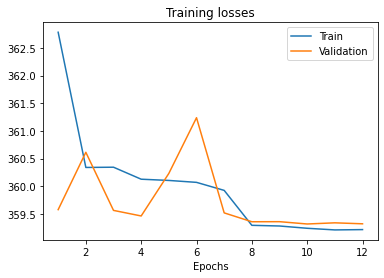

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
e = len(train_losses)
x_axis = np.arange(1, e + 1, 1)
plt.plot(x_axis, train_losses, label = "Train")
plt.plot(x_axis, val_losses, label = "Validation")
plt.legend()
plt.title('Training losses')
plt.xlabel("Epochs")
plt.show()

In [ ]:
# count = 0
# loss_dict = {}
# with torch.no_grad(): 
#     for index, row in df_sample.iterrows():
#         x = torch.tensor(row.values, dtype=torch.float).to(device)
#         y_pred = model(x)

#         loss = torch.sqrt(loss_fn(y_pred, y[count]))
#         count += 1

#         loss_dict[index] = loss

In [ ]:
# indexes = list(sorted(loss_dict))
# indexes[-11:-1]

In [34]:
df_orig = pd.read_csv("processed_train.csv")

In [35]:
torch.save(model, "MLP_embed_full_data")

In [ ]:
#model = torch.load("MLP2.5")

In [36]:
df_test = pd.read_csv("processed_test.csv")
df_out = df_test["TRIP_ID"].to_frame()
df_test = df_test.drop(columns=["Unnamed: 0", "TRIP_ID", "DAY_TYPE_A", "DAY_TYPE_B", "DAY_TYPE_C"])


In [37]:
df_test["MON"] = df_test["MON"] - 1
df_test["DAY"] = df_test["DAY"] - 1

In [38]:
df_test.head()

,ORIGIN_STAND,TAXI_ID,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C
0,15.0,190,7,13,17,3,0,1,0
1,57.0,37,7,13,17,3,0,1,0
2,15.0,129,7,13,17,3,0,1,0
3,53.0,171,7,13,17,3,0,1,0
4,18.0,217,7,13,17,3,0,1,0


In [39]:
x_test = [torch.tensor(df_test.iloc[i].values,dtype=torch.float).to(device) for i in range(len(df_test))]

In [40]:
x_test = torch.utils.data.DataLoader(x_test)

In [41]:
model.eval()
with torch.no_grad(): 
    df_out["TRAVEL_TIME"] = [float(model(x).cpu()) for x in x_test]
df_out.head()

df_out.to_csv("my_pred.csv", index=None)

In [ ]:
#TODO Implement accuracy or smthing for training
#Do something with validation (make a validation set)